In [1]:
from pypower.api import loadcase, runopf, ppoption
from pypower.idx_brch import *
from pypower.idx_bus import *
from pypower.idx_gen import *
from pypower.idx_cost import *
from pypower.ext2int import ext2int
import oct2py
import numpy as np
from numpy import r_
import math
import os
from tqdm import tqdm
from oct2py import Oct2Py
octave = Oct2Py()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import pickle
import shutil
import cvxpy as cp
if shutil.which('latex') is None:
    LATEX_AVAILABLE = False
else:
    LATEX_AVAILABLE = True
if LATEX_AVAILABLE:
    plt.rcParams['font.size'] = 14
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
    
MAX_BUS = 1500 # upper limit of number of buses in cases to be considered

In [2]:
# get all cases in current directory
current_directory = os.getcwd()
all_files_and_directories = os.listdir(current_directory)
case_files = [os.path.join(current_directory, f) for f in all_files_and_directories if f.endswith('.m') and os.path.isfile(os.path.join(current_directory, f))]

cases, casenames = [], []
cases_full, casenames_full = [], []
for cf in (t:=tqdm(case_files)):
    octave.source(os.path.basename(cf))
    cname = os.path.basename(cf).split('.')[0]
    num_buses = None
    # determine number of buses in the case from its name
    for ci in cname.split('_'):
        if 'case' in ci:
            num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
    # fitler out cases with more buses than MAX_BUS
    if num_buses <= MAX_BUS:
        # convert to internal indexing
        case_correct_idx = ext2int(loadcase(octave.feval(cname)))
        # append
        cases.append(case_correct_idx)
        casenames.append(cname)
    t.set_description(cname)

pglib_opf_case793_goc: 100%|███████████████████████████████████████████████████████████████████████████████████| 66/66 [00:39<00:00,  1.68it/s]


Status of constraints:
        DISABLE_MODEL: False
        DISABLE_FLOWLIMS: True
        DISABLE_ANG: False
        DISABLE_SOCR: False
        DISABLE_BALANCE: False
        DISABLE_VLIMS: False
        DISABLE_GENLIMS: False
        FIT_FLOWLIMS: False
        
pglib_opf_case60_c solved!



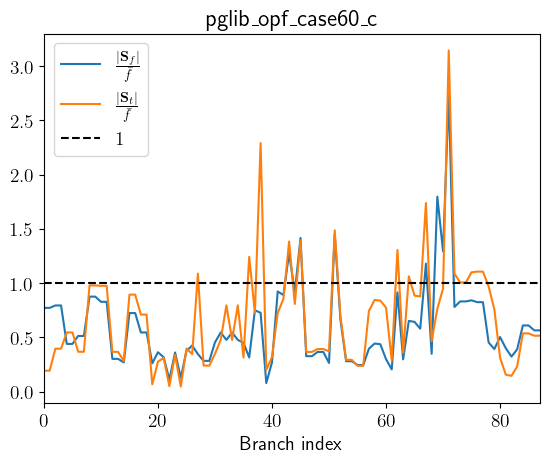

pglib_opf_case39_epri solved!



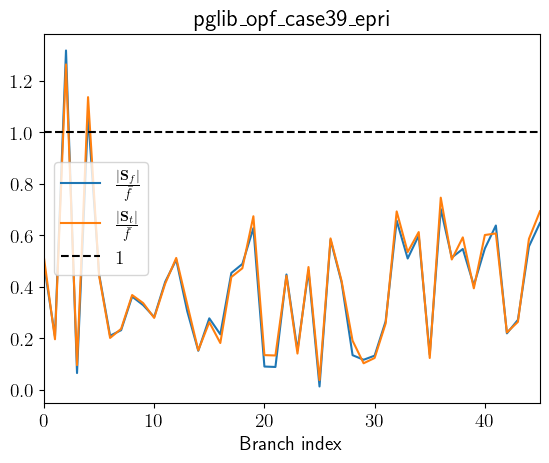

pglib_opf_case240_pserc solved!



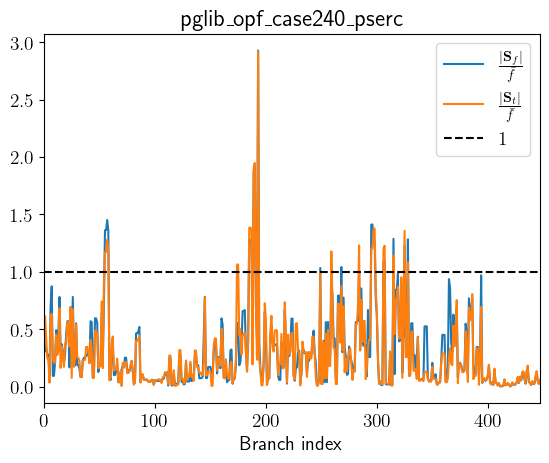

pglib_opf_case5_pjm solved!



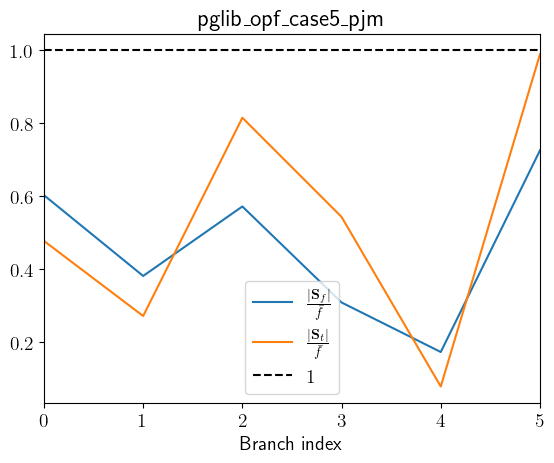

pglib_opf_case500_goc solved!



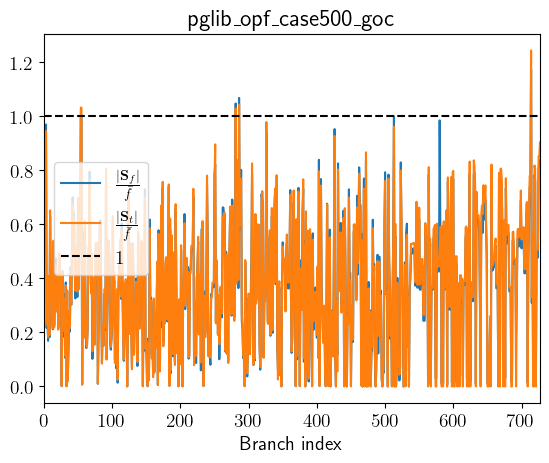

pglib_opf_case57_ieee encountered solver error!

pglib_opf_case3_lmbd solved!



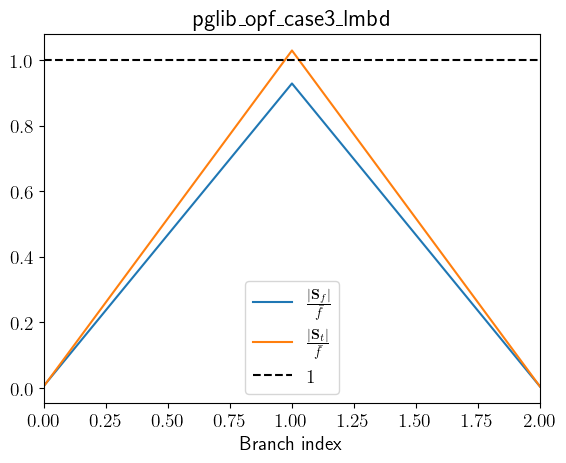

pglib_opf_case89_pegase not solved!

pglib_opf_case89_pegase encountered solver error!

pglib_opf_case200_activ solved!



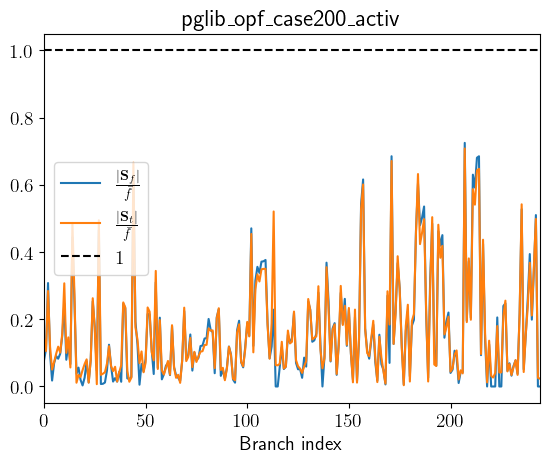

pglib_opf_case197_snem solved!



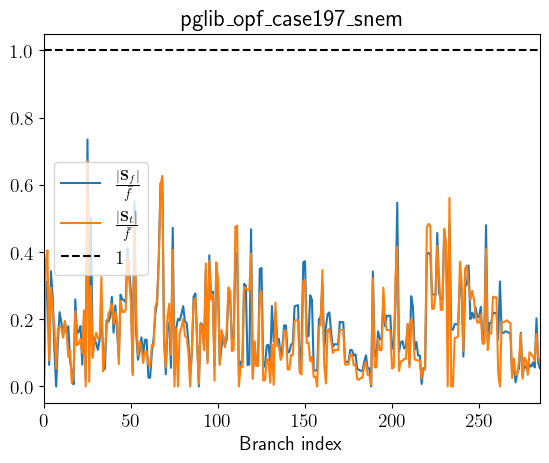

pglib_opf_case30_ieee solved!



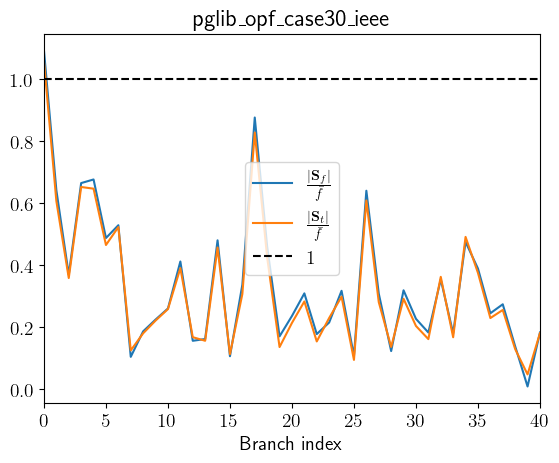

pglib_opf_case14_ieee solved!



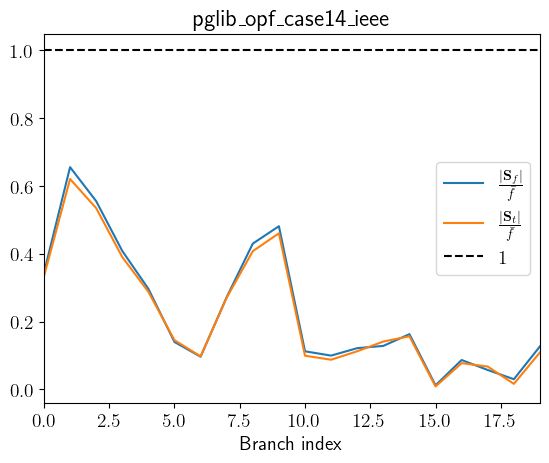

pglib_opf_case24_ieee_rts solved!



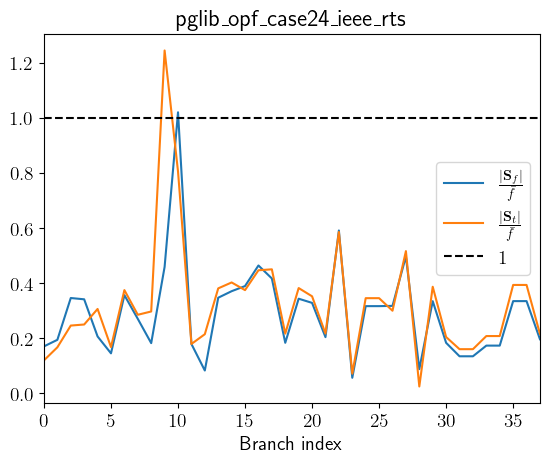

pglib_opf_case30_as solved!



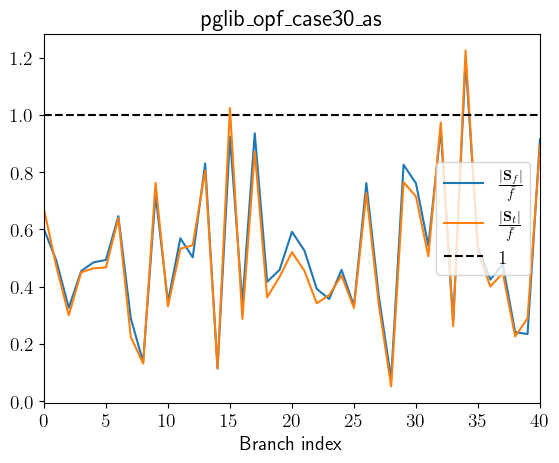

pglib_opf_case73_ieee_rts solved!



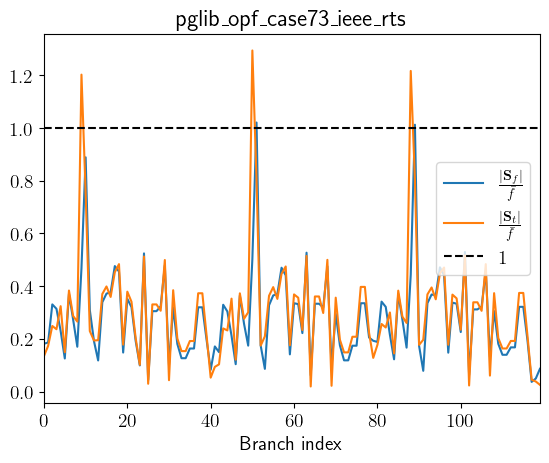

pglib_opf_case588_sdet solved!



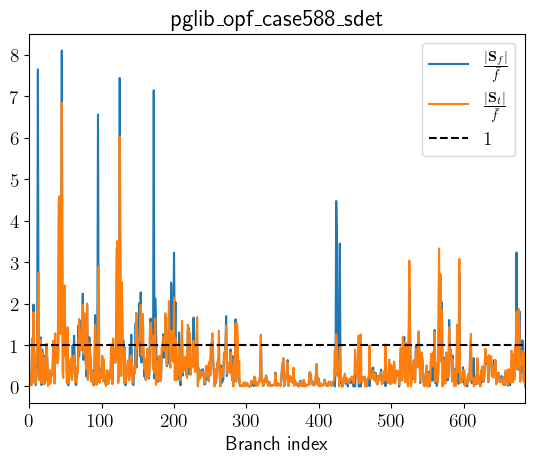

pglib_opf_case118_ieee solved!



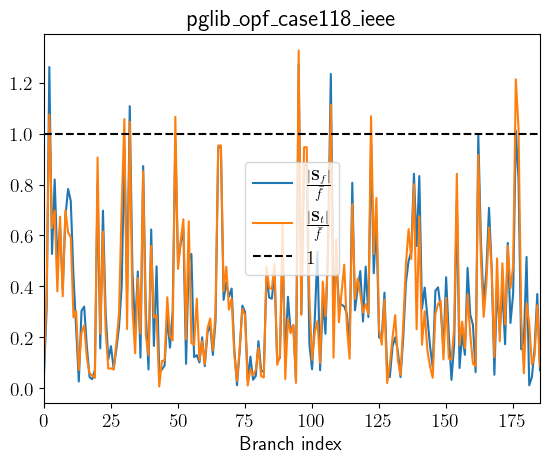

pglib_opf_case179_goc solved!



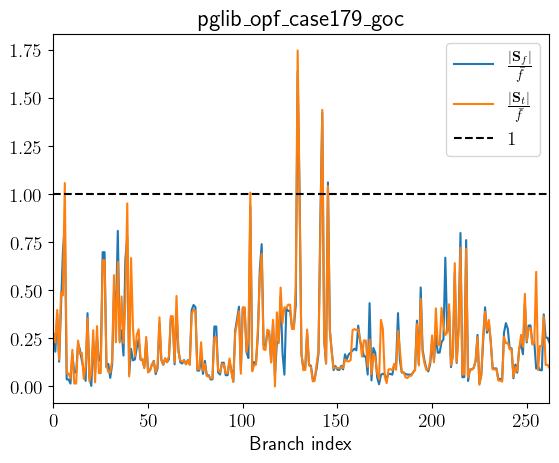

pglib_opf_case300_ieee not solved!

pglib_opf_case300_ieee encountered solver error!

pglib_opf_case162_ieee_dtc solved!



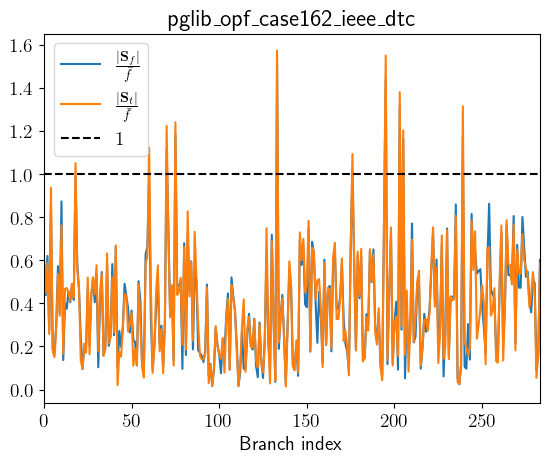

pglib_opf_case1354_pegase solved!



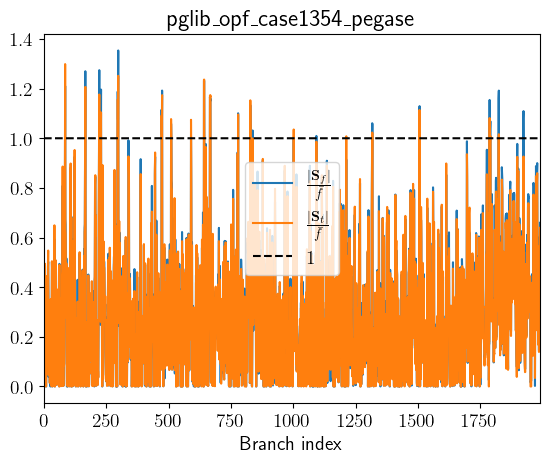

pglib_opf_case793_goc solved!



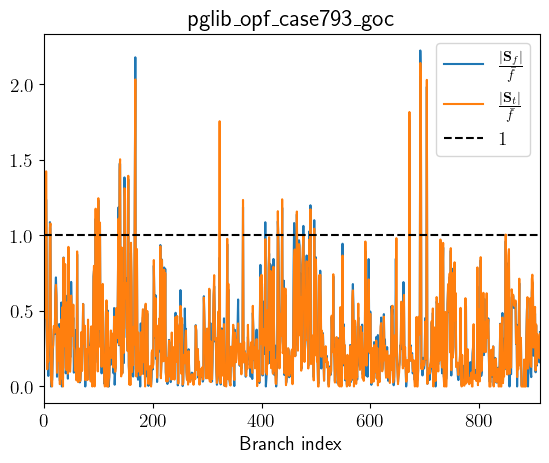

Solved 79.16666666666667 percent of cases.


In [3]:
# this_case = cases[0]

# CVXPY SWITCHES FOR ENABLING/DISABLING CONSTRAINTS
DISABLE_MODEL = False
DISABLE_FLOWLIMS = True
DISABLE_ANG = False
DISABLE_SOCR = False
DISABLE_BALANCE = False
DISABLE_VLIMS = False
DISABLE_GENLIMS = False
FIT_FLOWLIMS = False # use scalar multiplier to 'fit' flowlims into feasibility # TEST
print(f'''Status of constraints:
        DISABLE_MODEL: {DISABLE_MODEL}
        DISABLE_FLOWLIMS: {DISABLE_FLOWLIMS}
        DISABLE_ANG: {DISABLE_ANG}
        DISABLE_SOCR: {DISABLE_SOCR}
        DISABLE_BALANCE: {DISABLE_BALANCE}
        DISABLE_VLIMS: {DISABLE_VLIMS}
        DISABLE_GENLIMS: {DISABLE_GENLIMS}
        FIT_FLOWLIMS: {FIT_FLOWLIMS}
        ''')

# RECORDS FOR SOLVED AND UNSOLVED
solved, unsolved = 0,0

# ENABLE FLOWLIMS IF FIT_FLOWLIMS IS SET # TEST
if FIT_FLOWLIMS:
    DISABLE_FLOWLIMS = False

for cn,this_case in zip(casenames,cases):
    
    # LOAD DATA
    # baseMVA
    baseMVA = this_case['baseMVA']
    # bus data
    bus_list = this_case['bus'][:,BUS_I].astype(int)
    bus_vmin, bus_vmax = this_case['bus'][:,VMIN], this_case['bus'][:,VMAX]
    bus_pd, bus_qd = this_case['bus'][:,PD], this_case['bus'][:,QD]
    bus_gs, bus_bs = this_case['bus'][:,GS], this_case['bus'][:,BS]
    # branches
    from_bus = this_case['branch'][:,F_BUS]
    to_bus = this_case['branch'][:,T_BUS]
    br_r = this_case['branch'][:,BR_R]
    br_x = this_case['branch'][:,BR_X]
    br_b = this_case['branch'][:,BR_B]
    tap = this_case['branch'][:,TAP]
    shift = this_case['branch'][:,SHIFT]
    angmin, angmax = this_case['branch'][:,ANGMIN], this_case['branch'][:,ANGMAX]
    flow_lim = this_case['branch'][:,RATE_A]
    branch_list = [((f,t),(t,f),l) for f,t,l in zip(from_bus.astype(int),to_bus.astype(int),range(from_bus.size))] # forward and reversed graph
    # generators
    gen_to_bus = this_case['gen'][:,GEN_BUS]
    gen_mbase = this_case['gen'][:,MBASE]
    gen_pmax, gen_pmin = this_case['gen'][:,PMAX], this_case['gen'][:,PMIN]
    gen_qmax, gen_qmin = this_case['gen'][:,QMAX], this_case['gen'][:,QMIN]
    
    # PRE-PROCESSING DATA
    # normalization to pu
    bus_pd, bus_qd, bus_gs, bus_bs, gen_pmax, gen_qmax, gen_pmin, gen_qmin, flow_lim = \
    bus_pd/baseMVA, bus_qd/baseMVA, bus_gs/baseMVA, bus_bs/baseMVA, gen_pmax/baseMVA, gen_qmax/baseMVA, gen_pmin/baseMVA, gen_qmin/baseMVA, flow_lim/baseMVA
    # insert 1 in tap ratios
    tap = np.where(np.abs(tap)<1e-5,1.,tap)
    # convert angle limits to radians
    angmin, angmax = np.radians(angmin), np.radians(angmax)
    # convert 0 flow lims to large number
    flow_lim = np.where(np.abs(flow_lim)<1e-5,10000.,flow_lim)
    
    # LAMBDA HELPER FUNCTIONS
    gen_on_bus = lambda i: np.where(gen_to_bus == i)[0] # return list og gens attached to bus
    out_lines = lambda i: np.array([w[2] if w[0][0]==i else np.inf for w in branch_list])[np.array([w[2] if w[0][0]==i else np.inf for w in branch_list])!=np.inf].astype(int)
    in_lines = lambda i: np.array([w[2] if w[0][1]==i else np.inf for w in branch_list])[np.array([w[2] if w[0][1]==i else np.inf for w in branch_list])!=np.inf].astype(int)
    
    # NUMBER OF DIFFERENT ELEMENTS
    n_bus = len(bus_list)
    n_branch = len(branch_list)
    n_gen = len(gen_to_bus)
    
    # CVXPY VARIABLES
    Sf = cp.Variable(n_branch,complex=True) # p.u.
    St = cp.Variable(n_branch,complex=True) # p.u.
    Sgen = cp.Variable(n_gen,complex=True) # p.u.
    U = cp.Variable(n_bus,nonneg=True) # p.u.
    W = cp.Variable(n_branch,complex=True) # p.u.
    if FIT_FLOWLIMS: # TEST
        scale = cp.Variable(n_branch,nonneg=True)
    
    # CVXPY CONSTRAINTS
    constr = []
    # bus constraints (non-balance)
    for busid in bus_list:
        if not DISABLE_VLIMS:
            constr.append(U[busid] <= bus_vmax[busid]**2)
            constr.append(U[busid] >= bus_vmin[busid]**2)
    # branch constraints
    for br in branch_list:
        brf, brr, brid = br
        yl, b = 1 / (br_r[brid] + 1j * br_x[brid]), br_b[brid]
        tl = tap[brid] * (math.cos(shift[brid]) + 1j * math.sin(shift[brid]))
        yff, ytt, yft, ytf = (yl + 1j * (b)) / (tl*tl.conjugate()) , (yl + 1j * (b)), - yl / tl.conjugate(), -yl / tl
        if not DISABLE_MODEL:
            # forward and reverse flows
            frm, to = brf[0], brf[1]
            constr.append(Sf[brid] == yff.conjugate()*U[frm] + yft.conjugate()*W[brid])
            constr.append(St[brid] == ytt.conjugate()*U[to] + ytf.conjugate()*cp.conj(W[brid]))
        if not DISABLE_FLOWLIMS:
            # flow limits
            if FIT_FLOWLIMS: # TEST
                constr.append(cp.power(cp.real(Sf),2) + cp.power(cp.imag(Sf),2) <= scale[brid]*flow_lim[brid]**2)
                constr.append(cp.power(cp.real(St),2) + cp.power(cp.imag(St),2) <= scale[brid]*flow_lim[brid]**2)
            else: # PRE-TEST
                constr.append(cp.power(cp.real(Sf),2) + cp.power(cp.imag(Sf),2) <= flow_lim[brid]**2)
                constr.append(cp.power(cp.real(St),2) + cp.power(cp.imag(St),2) <= flow_lim[brid]**2)
        if not DISABLE_ANG:
            # angle limits
            constr.append(cp.imag(W[brid]) <= math.tan(angmax[brid]) * cp.real(W[brid]))
            constr.append(cp.imag(W[brid]) >= math.tan(angmin[brid]) * cp.real(W[brid]))
        if not DISABLE_SOCR:
            # second order cones
            frm, to = brf[0], brf[1]
            constr.append(cp.norm(cp.hstack([U[frm]-U[to],2*cp.real(W[brid]),2*cp.imag(W[brid])]),2) <= U[frm]+U[to])
    # generator constraints
    if not DISABLE_GENLIMS:
        constr.append(cp.real(Sgen) <= gen_pmax)
        constr.append(cp.real(Sgen) >= gen_pmin)
        constr.append(cp.imag(Sgen) <= gen_qmax)
        constr.append(cp.imag(Sgen) >= gen_qmin)
    else:
        constr.append(cp.real(Sgen) >= gen_pmin)
    # bus constraints (balance)
    for busid in bus_list:
        Sd = bus_pd[busid] + 1j * bus_qd[busid]
        gens = gen_on_bus(busid)
        Sgen_total = cp.sum([Sgen[gid] for gid in gens]) if gens.size > 0 else 0
        Sf_total = cp.sum([Sf[brid] for brid in out_lines(busid)]) if out_lines(busid).size >0 else 0
        St_total = cp.sum([St[brid] for brid in in_lines(busid)]) if in_lines(busid).size >0 else 0
        Ys = bus_bs[busid] + 1j * bus_gs[busid]
        if not DISABLE_BALANCE:
            constr.append(Sgen_total - Sd - Ys*U[busid] == Sf_total + St_total)
    if FIT_FLOWLIMS: # TEST
        obj = cp.Minimize(cp.sum(scale))
    else: # PRE-TEST
        obj = cp.Minimize(1)
    prob = cp.Problem(obj,constr)
    # solve problem and record results
    try:
        prob.solve(solver='MOSEK',verbose=False)
        if prob.status not in ['infeasible','unbounded']:
            print(f"{cn} solved!\n")
            solved += 1
        else:
            print(f"{cn} not solved!\n")
            unsolved += 1
        if FIT_FLOWLIMS: # TEST
            plt.plot(scale.value)
            plt.plot(np.ones_like(scale.value),'k--')
            plt.xlabel('Branch index')
            plt.xlim([0,scale.value.size-1])
            plt.ylabel('Flowlim scale for feas.')
            plt.title(cn)
            plt.show()
        else:
            plt.plot(np.abs(Sf.value) / flow_lim, label=r'$\frac{|\mathbf{S}_f|}{\bar{f}}$')
            plt.plot(np.abs(St.value) / flow_lim, label=r'$\frac{|\mathbf{S}_t|}{\bar{f}}$')
            plt.plot(np.ones_like(flow_lim),'k--',label=r'$1$')
            plt.legend()
            plt.xlabel('Branch index')
            plt.xlim([0,flow_lim.size-1])
            plt.title(cn)
            plt.show()
    except:
        print(f"{cn} encountered solver error!\n")
        unsolved += 1
    # break

# DISPLAY OUTCOME
print(f"Solved {100*solved/(solved+unsolved)} percent of cases.")